In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_addons as tfa
from sklearn.metrics import f1_score
from tensorflow import keras
from tqdm import tqdm

from lib.utils import fix_random_seed, read_json
from src.config import c
from src.data_utils import (
    boost_multiple_occurences,
    geofilter_predictions,
    normalize_soundscapes_df,
    predictions_to_text_labels,
    read_soundscapes_info,
)
from src.generator import Generator
from src.geo_filter import filters as geo_filters
from src.models import Div, SinCos, YMToDate
from src.services import get_msg_provider, get_wave_provider

from tqdm import tqdm

In [2]:
IN_CSV = "/kaggle/input/birdclef-2021/train_soundscape_labels.csv"
MODEL = "/kaggle/input/bc21-models/B1_nrsw_2.h5"

In [3]:
# metadata from model training run
meta = read_json(MODEL.replace(".h5", ".json"))

for k in [
    "WORK_DIR",
    "CACHE_DIR",
    "COMPETITION_DATA",
    "SRC_DATA_DIRS",
    "CACHE_AUDIO_FRAGMENTS",
]:
    meta["config"][k] = c[k]

In [4]:
# prepare soundscapes df
df = pd.read_csv(IN_CSV)
df = normalize_soundscapes_df(df, quiet=True, seconds=5)

In [5]:
if os.path.isfile("Y_pred.npy"):

    Y_pred = np.load("Y_pred.npy")

else:

    # load model
    model = keras.models.load_model(
        MODEL,
        custom_objects={
            "SinCos": SinCos,
            "Div": Div,
            "YMToDate": YMToDate,
        },
    )

    # create generator
    input_shape = model.get_layer("i_msg").input_shape[0][1:]
    wave_p = get_wave_provider(meta["config"])
    msg_p = get_msg_provider(
        meta["config"], n_mels=input_shape[0], time_steps=input_shape[1]
    )

    g = Generator(
        df=df,
        shuffle=False,
        augmentation=None,
        rating_as_sw=False,
        rareness_as_sw=False,
        msg_provider=msg_p,
        wave_provider=wave_p,
        msg_as_rgb=(3 == input_shape[-1]),
        geo_coordinates_bins=meta["config"]["GEO_COORDINATES_BINS"],
        batch_size=1,
    )

    # predict
    Y_pred = model.predict(
        x=g,
        use_multiprocessing=True,
        workers=4,
        verbose=1,
    )

    np.save("Y_pred", Y_pred)

df["_y_pred"] = list(map(lambda x: x, Y_pred))

In [6]:
# scores = {}

# for m in np.arange(2, 10, 1):

#     print(m)
#     bs = []
#     f1s = []

#     # convert predictions to words
#     for b in tqdm(np.arange(1.05, 3, 0.05)):

#         df = boost_multiple_occurences(
#             df=df,
#             labels=meta["labels"],
#             pred_col="_y_pred",
#             out_col="_y_pred_boosted",
#             boost_coef=b,
#             max_boost_coef=b * 4,
#             threshold=0.5,
#         )

#         bs.append(b)
#     #     print("\n", b)

#         labels_pred = predictions_to_text_labels(
#             np.array(list(df["_y_pred"])),
#             meta["labels"],
#             default_label="nocall",
#             max_labels=None,
#             priority_to_nocall=False,
#         )

#         df["birds"] = labels_pred

#         labels_pred = predictions_to_text_labels(
#             np.array(list(df["_y_pred_boosted"])),
#             meta["labels"],
#             default_label="nocall",
#             max_labels=None,
#             priority_to_nocall=False,
#         )

#         df["birds_boosted"] = labels_pred

#     #     f1 = f1_score(
#     #         df["_primary_labels"],
#     #         df["birds"],
#     #         labels=meta["labels"],
#     #         average="micro",
#     #     )
#     #     print("f1:", f1)

#         f1s.append(
#             f1_score(
#                 df["_primary_labels"],
#                 df["birds_boosted"],
#                 labels=meta["labels"],
#                 average="micro",
#             )
#         )

#     #     print("f1 boosted:", f1s[-1])
    
#     scores[m] = (bs, f1s)

In [7]:
# # plt.plot(bs, range(len(bs)))
# for k, v in scores.items():
#     plt.plot(*v)

In [8]:
# np.argmax(scores[k][1])
# scores[2][0][27]

In [9]:
# df[df["_primary_labels"] != df["birds"]].to_csv("wrong.csv")

In [10]:
# print(
#     "f1:",
#     f1_score(
#         df["_primary_labels"],
#         df["birds"],
#         labels=meta["labels"],
#         average="micro",
#     ),
# )

# print(
#     "f1:",
#     f1_score(
#         df["_primary_labels"],
#         df["birds_boosted"],
#         labels=meta["labels"],
#         average="micro",
#     ),
# )

In [11]:
# df[["row_id", "birds"]].to_csv("submission.csv", index=False)

In [16]:
# try different lowering coeffs

b = 2.4
scores = {}


for d in tqdm(np.arange(1.20, 1.30, 0.0005)):

    df = boost_multiple_occurences(
        df=df,
        labels=meta["labels"],
        pred_col="_y_pred",
        out_col="_y_pred_boosted",
        boost_coef=b,
        max_boost_coef=b * 4,
        threshold=0.5,
        lowering_coeff=d
    )

    labels_pred = predictions_to_text_labels(
        np.array(list(df["_y_pred"])),
        meta["labels"],
        default_label="nocall",
        max_labels=None,
        priority_to_nocall=False,
    )

    df["birds"] = labels_pred

    labels_pred = predictions_to_text_labels(
        np.array(list(df["_y_pred_boosted"])),
        meta["labels"],
        default_label="nocall",
        max_labels=None,
        priority_to_nocall=False,
    )

    df["birds_boosted"] = labels_pred

    f1 = f1_score(
        df["_primary_labels"],
        df["birds_boosted"],
        labels=meta["labels"],
        average="micro",
    )

    scores[d] = f1

100%|██████████| 201/201 [01:11<00:00,  2.83it/s]


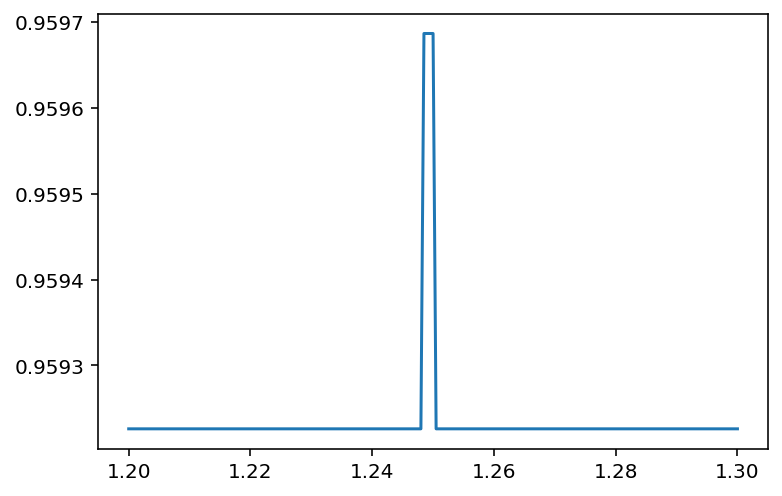

In [17]:
plt.plot(scores.keys(), scores.values())